In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import wmfdata as wmf

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [5]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)

def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1)
M_fmt = mpl.ticker.FuncFormatter(M_str)
comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

In [5]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Monthly active editors

In [6]:
m["existing_active_editors"] = m["active_editors"] - m["new_active_editors"] - m["second_month_active_editors"]
m = m.drop("active_editors", axis = 1)
eds = m[["existing_active_editors", "second_month_active_editors", "new_active_editors"]]

In [7]:
eds.columns = ['existing active editors', 'second month active editors',
       'new (first-month) active editors']
eds.tail()

,existing active editors,second month active editors,new (first-month) active editors
month,,,
2017-12-01,61019.0,4152.0,14387.0
2018-01-01,64391.0,3353.0,16678.0
2018-02-01,59777.0,4134.0,15052.0
2018-03-01,64218.0,4347.0,17625.0
2018-04-01,62907.0,4739.0,16059.0


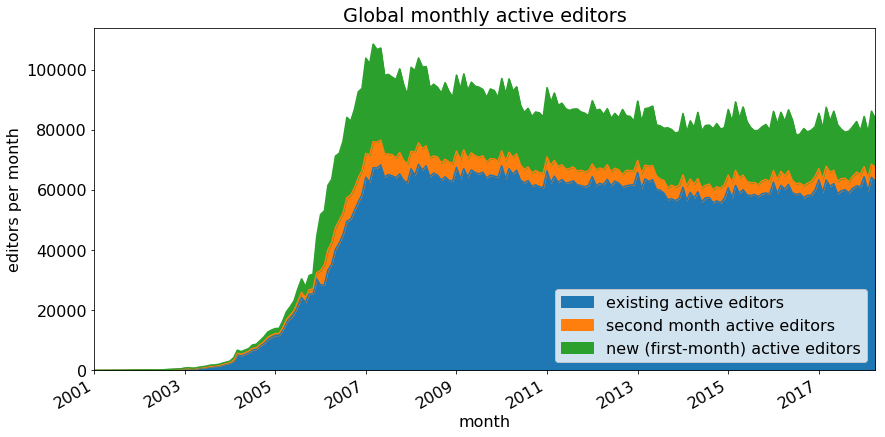

In [8]:
ax = eds.plot.area()
plt.title("Global monthly active editors")
plt.ylabel("editors per month")
plt.autoscale(enable=True, axis="x", tight=True);

## Very active editors

In [ ]:
vae = wmf.mariadb.run("""
    select 
        month, 
        count(*) as very_active_editors
    from (
        select
            month,
            -- Convert from BINARY to CHAR so that case-insentive regexes work
            convert(user_name using utf8) as name,
            sum(content_edits) as content_edits,
            max(bot_flag) as bot_flag,
            min(user_registration) as reg
        from staging.editor_month
        where 
            month >= "{start}" and
            local_user_id != 0
        group by month, name
    ) global_edits
    where
        content_edits >= 100 and
        -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
        -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
        bot_flag = 0 and (
            name not regexp "bot\\\\b" or
            name in ("Paucabot", "Niabot", "Marbot")    
        )
    group by month;
""".format(start="2014-06-01"))

In [12]:
vae["month"] = vae["month"].apply(pd.to_datetime)
vae = vae.set_index("month")

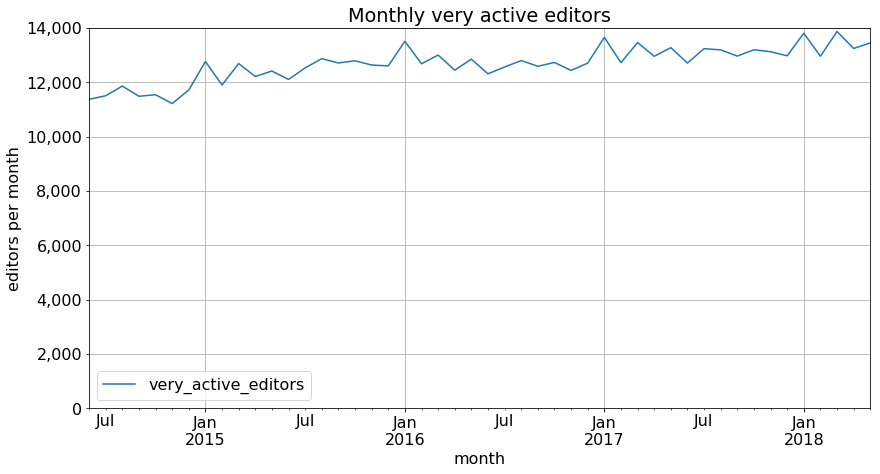

In [49]:
vae.plot()
ax = plt.gca()
plt.title("Monthly very active editors")
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("editors per month")
plt.ylim(ymin=0)
plt.autoscale(enable=True, axis="x", tight=True)
ax.grid(True)
plt.savefig('vae.png', bbox_inches='tight');

## Very active editors by project

In [25]:
pvae_raw = wmf.mariadb.run("""
    select 
        month,
        wiki,
        count(*) as very_active_editors
    from staging.editor_month
    where
        content_edits >= 100 and
        local_user_id != 0 and
        month >= "{start}" and
        -- A user is a bot if they have a matching name or have the bot flag on *any* wiki
        -- See https://meta.wikimedia.org/wiki/Research:Active_editor and https://meta.wikimedia.org/wiki/Research:Bot_user
        bot_flag = 0 and (
            convert(user_name using utf8) not regexp "bot\\\\b" or
            convert(user_name using utf8) in ("Paucabot", "Niabot", "Marbot")    
        )
    group by wiki, month;
""".format(start="2014-06-01"))

In [40]:
pvae = pvae_raw.pivot(index="month", columns="wiki").fillna(0)
pvae.columns = pvae.columns.droplevel(0)
pvae.index = pd.to_datetime(pvae.index)
pvae.tail()

wiki,abwiki,acewiki,adywiki,afwiki,afwiktionary,akwiki,alswiki,amwiki,amwiktionary,angwiki,...,zh_min_nanwiktionary,zh_yuewiki,zhwiki,zhwikibooks,zhwikinews,zhwikiquote,zhwikisource,zhwikivoyage,zhwiktionary,zuwiki
month,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,9.0,3.0,0.0,3.0,1.0,0.0,0.0,...,0.0,15.0,361.0,1.0,0.0,0.0,8.0,2.0,4.0,1.0
2018-02-01,1.0,1.0,0.0,14.0,2.0,0.0,3.0,1.0,0.0,0.0,...,0.0,9.0,344.0,1.0,0.0,0.0,8.0,2.0,4.0,1.0
2018-03-01,0.0,0.0,0.0,9.0,2.0,1.0,3.0,1.0,0.0,1.0,...,1.0,14.0,370.0,1.0,0.0,2.0,6.0,2.0,3.0,1.0
2018-04-01,0.0,0.0,0.0,6.0,0.0,1.0,2.0,1.0,0.0,1.0,...,0.0,7.0,401.0,1.0,0.0,0.0,9.0,2.0,2.0,1.0
2018-05-01,1.0,0.0,0.0,9.0,0.0,0.0,3.0,1.0,0.0,1.0,...,0.0,10.0,371.0,2.0,1.0,1.0,7.0,2.0,2.0,0.0


In [41]:
def segment(wiki):
    if wiki == "enwiki":
        return "English Wikipedia"
    elif wiki == "commonswiki":
        return "Commons"
    elif wiki == "wikidatawiki":
        return "Wikidata"
    else:
        return "Other projects"

pvae_seg = pvae.groupby(segment, axis = 1).sum()

In [42]:
pvae_seg

,Commons,English Wikipedia,Other projects,Wikidata
month,,,,
2014-06-01,1327.0,3125.0,6788.0,832.0
2014-07-01,1304.0,3194.0,6908.0,814.0
2014-08-01,1329.0,3254.0,7115.0,864.0
2014-09-01,1702.0,3033.0,6723.0,752.0
2014-10-01,1525.0,3115.0,6946.0,755.0
2014-11-01,1315.0,3042.0,6809.0,765.0
2014-12-01,1311.0,3188.0,7121.0,858.0
2015-01-01,1354.0,3467.0,7898.0,937.0
2015-02-01,1294.0,3190.0,7292.0,891.0


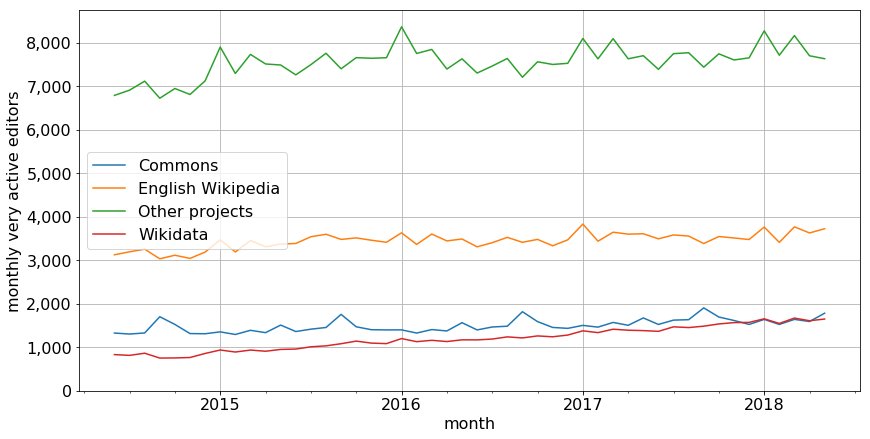

In [47]:
pvae_seg.plot(ylim=0)
ax = plt.gca()
ax.grid(True)
ax.yaxis.set_major_formatter(comma_fmt)
plt.ylabel("monthly very active editors")
plt.savefig('pvae.png', bbox_inches='tight')